In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [ ]:
model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
# if HOST_ID == 'workstation':
# model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
# else:
model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

In [2]:
structure = 'VCA'

In [3]:
dataset_settings

classes      network_model            stain  \
dataset_id                                                                  
20                                NaN       Inception-BN            nissl   
21                                NaN       Inception-BN            nissl   
22                                NaN       Inception-BN            nissl   
23          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
24          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
25          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
26                                NaN  inception-bn-blue            nissl   
27                                NaN  inception-bn-blue            nissl   
28                                NaN  inception-bn-blue            nissl   
29                                neg  inception-bn-blue            nissl   
30          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
31          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
32          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
33          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
34          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
35          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
36          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
37          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
38          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
39          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
40          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
41          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
50                                NaN  inception-bn-blue  neurotrace_blue   
51                                NaN  inception-bn-blue  neurotrace_blue   
60                                NaN                NaN            nissl   
61                                NaN                NaN            nissl   
62                                NaN                NaN            nissl   
70          pos/surPos/surNoclass/neg  inception-bn-blue            nissl   
71          pos/surPos/surNoclass/neg  inception-bn-blue  neurotrace_blue   
90                                NaN                NaN            nissl   
92                                NaN                NaN            nissl   
93                                NaN                NaN            nissl   
94                                NaN                NaN            nissl   
95                                NaN                NaN            nissl   
96                                NaN                NaN            nissl   
97                                NaN                NaN            nissl   
98                                NaN                NaN            nissl   
99                                NaN                NaN            nissl   

           margins_um  num_sample_per_class             stacks  \
dataset_id                                                       
20            200/500                  1000              MD585   
21            200/500                  1000              MD589   
22            200/500                  1000              MD594   
23                500                  1000              MD585   
24                500                  1000              MD589   
25                500                  1000              MD594   
26                NaN                  1000  MD594/MD589/MD585   
27                NaN                  1000              MD585   
28                NaN                  1000              MD589   
29                NaN                  1000              MD594   
30                200                  1000              MD585   
31                200                  1000              MD589   
32                200    

In [4]:
classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)
classifier_settings

model  margin_um train_set_id  \
classifier_id                                                      
30                                    lr        500        20/21   
31                                    lr        500        21/22   
32                                    lr        500        20/22   
33                                   gb1        500        20/21   
34                                   gb1        500        21/22   
35                                   gb1        500        20/22   
36                                   gb1        500        23/24   
37                                    lr        500        23/24   
38                                    lr        500  23/24/27/28   
39                                    lr        200  30/31/27/28   
40                                    lr       1000  33/34/27/28   
41                                    lr        500  36/37/27/28   
42                                    lr        500  39/40/27/28   
70             inception-bn-blue-softmax        500        60/61   
71             inception-bn-blue-softmax        500     60/61/62   
80                                    lr        500        23/24   
81                                    lr        500        23/24   
82                                    lr        500        23/24   
83                                    lr        500        23/24   
84                                    lr        500        23/24   
95                                   gb2        500           93   
96                                   gb2        500           95   
97                                   gb2        500           97   
98                                   gb2        500           99   
99                                    lr        500           99   

                             neg_composition  sample_weighting  \
classifier_id                                                    
30                      neg_has_all_surround               NaN   
31                      neg_has_all_surround               NaN   
32                      neg_has_all_surround               NaN   
33                      neg_has_all_surround               NaN   
34                      neg_has_all_surround               NaN   
35                      neg_has_all_surround               NaN   
36                      neg_has_all_surround               NaN   
37                      neg_has_all_surround               NaN   
38             neg_has_surround_and_negative               NaN   
39             neg_has_surround_and_negative               NaN   
40             neg_has_surround_and_negative               NaN   
41             neg_has_surround_and_negative               NaN   
42             neg_has_surround_and_negative               NaN   
70                      neg_has_all_surround               NaN   
71                      neg_has_all_surround               NaN   
80                      neg_has_all_surround               NaN   
81                      neg_has_all_surround               NaN   
82                      neg_has_all_surround               NaN   
83                      neg_has_all_surround               NaN   
84                      neg_has_all_surround               NaN   
95                      neg_has_all_surround               NaN   
96                      neg_has_all_surround               NaN   
97                      neg_has_all_surround               NaN   
98                      neg_has_all_surround               NaN   
99                      neg_has_all_surround               NaN   

                               input_img_version  svm_id  
classifier_id                                             
30                                  cropped_gray    30.0  
31                                  cropped_gray    31.0  
32                                  cropped_gray    32.0  
33                                  cropped_gray    33.0  
34                                  cropped_gray    34.0  
35

In [5]:
classifier_id = 38
classifier_properties = classifier_settings.loc[classifier_id]

margin_um = classifier_properties['margin_um']
feature_classifier_model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']
svm_id = int(classifier_properties['svm_id'])

In [6]:
# Determine which labels to load.

structures_to_sample = [structure]
# structures_to_sample = all_known_structures
# structures_to_sample = ['Pn']

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin_um]
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in all_known_structures
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_surround_and_negative':
    labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample

In [7]:
# Load training dataset.

# training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
# training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)

In [41]:
training_set_ids = [60, 61, 62]
training_patches, training_addresses = load_dataset_images(training_set_ids, labels_to_sample=labels_to_sample)

rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_addresses.pkl" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_addresses.pkl" "/shared/CSHL_classifiers/datasets/dataset_60/patch_addresses.pkl"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_images_VCA.hdf" "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_negative.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_negative.hdf" "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_negative.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500

rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_DC.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_DC.hdf" "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_DC.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_AP.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_AP.hdf" "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_AP.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_12N.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_60"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_60/patch_images_VCA_surround_500_12N.hdf" "/shared/CSHL_classifiers/datasets/dataset_6

rm -rf "/shared/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_SNR.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_61"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_SNR.hdf" "/shared/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_SNR.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_3N.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_61"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_3N.hdf" "/shared/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_3N.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_4N.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_61"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_61/patch_images_VCA_surround_500_4N.hdf" "/shared/CSHL_classifiers/datasets/dataset_

rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_7n.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_7n.hdf" "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_7n.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_Amb.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_Amb.hdf" "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_Amb.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_LC.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_LC.hdf" "/shared/CSHL_classifiers/datasets/dataset_

rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_SC.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_SC.hdf" "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_SC.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_IC.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_IC.hdf" "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_IC.hdf"
rm -rf "/shared/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_noclass.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_62"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_62/patch_images_VCA_surround_500_noclass.hdf" "/shared/CSHL_classifiers/datasets/d

In [ ]:
variants = range(0, 8)

In [44]:
training_features = {}
for s, ps in training_patches.iteritems():
    feats = []
    for v in variants:
        ps_var = rotate_all_patches_variant(ps, variant=v)
        feats_var = convert_image_patches_to_features(patches=ps_var, model=model, mean_img=mean_img, batch_size=batch_size)
        feats.append(feats_var)
    feats_arr = np.concatenate(feats)
    training_features[s] = feats_arr

In [54]:
neg_features, _ = load_datasets([27,28,29], labels_to_sample=negative_labels_to_sample)

rm -rf "/shared/CSHL_classifiers/datasets/dataset_29/patch_features.hdf" && mkdir -p "/shared/CSHL_classifiers/datasets/dataset_29"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_29/patch_features.hdf" "/shared/CSHL_classifiers/datasets/dataset_29/patch_features.hdf"


In [56]:
training_features['VCA_negative'] = neg_features['VCA_negative']

In [58]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

In [59]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [60]:
print structure

#############################
## Define Positive Samples ##
#############################

features_pos = training_features[structure]
n_pos = len(features_pos)
print n_pos, 'positive examples'

#############################
## Define Negative Samples ##
#############################

if neg_composition == 'neg_has_only_surround_noclass':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
elif neg_composition == 'neg_has_all_surround':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    for surr_s in all_known_structures:
        c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
        if c in labels_found:
            neg_classes.append(c)
elif neg_composition == 'neg_has_everything_else':
    neg_classes = [structure + '_negative']
elif neg_composition == 'neg_has_surround_and_negative':
    neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')]
    for surr_s in all_known_structures:
        c = convert_to_surround_name(structure, margin=margin_um, suffix=surr_s)
        if c in labels_found:
            neg_classes.append(c)
    neg_classes += [structure + '_negative']
else:
    raise Exception('neg_composition %s is not recognized.' % neg_composition)

features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])

n_neg = len(features_neg)
print n_neg, 'negative examples'

###########################
## Define Sample Weights ##
###########################

if sample_weighting == 'weighted':
    neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])

    sample_weights_neg = np.ones((n_neg,))
    sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
    sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
else:
    sample_weights = None

###########################################################################################

train_data = np.r_[features_pos, features_neg]
train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                     -np.ones((features_neg.shape[0], ))]

#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

#####################################
## Define feature_classifier_model ##
#####################################

if feature_classifier_model == 'lr':
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                             fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                             verbose=0, warm_start=False, n_jobs=1)

elif feature_classifier_model == 'lin_svc':
    clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
              probability=True, tol=0.001, cache_size=1000, max_iter=-1,
          decision_function_shape=None, random_state=None)


elif feature_classifier_model == 'lin_svc_calib':

    sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                            C=1.0, multi_class='ovr', 
                            fit_intercept=True, intercept_scaling=1, max_iter=100)
    clf = CalibratedClassifierCV(sv_uncalibrated)


elif feature_classifier_model == 'xgb1':
    clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                        silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                        min_child_weight=20, max_delta_step=0, subsample=.8, 
                        colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

elif feature_classifier_model == 'gb1':
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                     subsample=1., criterion='friedman_mse', 
                                     min_samples_split=50, min_samples_leaf=20, 
                                     min_weight_fraction_leaf=0.0, max_depth=3, 
                                     min_impurity_split=1e-07, init=None, random_state=None, 
                                     max_features=None, verbose=1, max_leaf_nodes=None, 
                                     warm_start=False, presort='auto')

elif feature_classifier_model == 'gb2':
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                     subsample=1., criterion='friedman_mse', 
                                     min_samples_split=50, min_samples_leaf=20, 
                                     min_weight_fraction_leaf=0.0, max_depth=5, 
                                     min_impurity_split=1e-07, init=None, random_state=None, 
                                     max_features=None, verbose=1, max_leaf_nodes=None, 
                                     warm_start=False, presort='auto')


else:
    sys.stderr.write('Setting is not recognized.\n')

t = time.time()    
clf.fit(train_data, train_labels, sample_weight=sample_weights)
sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

# clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
# create_parent_dir_if_not_exists(clf_fp)
# joblib.dump(clf, clf_fp)

# upload_to_s3(clf_fp)

VCA
24000 positive examples
75000 negative examples


Fitting classifier: 65.08 seconds


In [11]:
####################

model_name = 'inception-bn-blue'
classifier_id = 38

classifier_properties = classifier_settings.loc[classifier_id]
assert dataset_settings.loc[int(classifier_properties['train_set_id'].split('/')[0])]['network_model'] == model_name
svm_id = int(classifier_properties['svm_id'])

########################

available_classifiers = {svm_id: DataManager.load_classifiers(classifier_id=svm_id)}

rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/5N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/6N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/7N_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifi

rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/SC_clf_setting_38.dump"
rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/IC_clf_setting_38.dump"


In [61]:
svm_id = 999
available_classifiers = {svm_id: {structure: clf}}

In [62]:
stack = 'MD661'
section_to_filename = metadata_cache['sections_to_filenames'][stack]

windowing_id = 3

windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]
half_size = patch_size/2

grid_spec = (patch_size, spacing, w, h)

sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [63]:
filenames = ['MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111']

In [64]:
# roi_xmin = 414 * 8
# roi_ymin = 1212 * 8
# roi_w = 551 * 8
# roi_h = 528 * 8

roi_xmin = 968 * 8
roi_ymin = 827 * 8
roi_w = 435 * 8
roi_h = 357 * 8

In [65]:
structures = ['VCA']

In [66]:
def rotate_all_patches_variant(patches, variant):

    if variant == 0:
        patches_variant = patches
    elif variant == 1:
        patches_variant = [p.T[::-1] for p in patches]
    elif variant == 2:
        patches_variant = [p[::-1] for p in patches]
    elif variant == 3:
        patches_variant = [p[:, ::-1] for p in patches]
    elif variant == 4:
        patches_variant = [p[::-1, ::-1] for p in patches]
    elif variant == 5:
        patches_variant = [p.T for p in patches]
    elif variant == 6:
        patches_variant = [p.T[::-1, ::-1] for p in patches]
    elif variant == 7:
        patches_variant = [p.T[:, ::-1] for p in patches]
    return patches_variant

In [67]:
def rotate_all_patches(patches_enlarged, r, output_size=224):
    """
    Args:
        patches_enlarged: 
        r (int): rotation angle in degrees
        output_size (int): size of output patches
    """
    
    half_size = output_size/2
    patches_rotated = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
                                                                p.shape[0]/2-half_size:p.shape[0]/2+half_size] 
                                             for p in patches_enlarged]))
    return patches_rotated

In [68]:
def convert_image_patches_to_features(patches, model, mean_img, batch_size):
    """
    Args:
        patches (list of (224,224)-ndarrays of uint8)
        model (mxnet.Module)
        mean_img ((224,224)-ndarray of uint8) : the mean image
        batch_size (int): batch size
    """
    patches_mean_subtracted = patches - mean_img
    patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

    data_iter = mx.io.NDArrayIter(
                    patches_mean_subtracted_input, 
                    batch_size=batch_size,
                    shuffle=False)
    outputs = model.predict(data_iter, always_output_list=True)
    features = outputs[0].asnumpy()

    return features

In [86]:
variants = range(0, 8)

In [87]:
scoremap_viz_allSchemes_allFns_allStructs = defaultdict(lambda: defaultdict(dict))

for fn in filenames:

    ####################

    t = time.time()
    mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, fn=fn)
    indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb, 
                                    bbox_lossless=(roi_xmin,roi_ymin,roi_w,roi_h))
    sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

    n = len(indices_roi)
    sys.stderr.write('%d samples.\n' % n)

    ############################

    sample_locations_roi = sample_locations[indices_roi]

    ###########################

    t = time.time()
    img_blue = DataManager.load_image_v2(stack=stack, fn=fn, prep_id=2, resol='lossless')[..., 2]
    sys.stderr.write('Read: %.2f seconds\n' % (time.time() - t))
    
#     for low in np.arange(100, 500, 50):
#     for low in np.arange(900, 2000, 100):
#     for low in [1300]:
    for low in np.r_[np.arange(900, 2000, 100), -100]:

    #     probs_allFns_allClasses = {}
    #     scoremaps_allFns_allClasses = {}

        high = 0

        t = time.time()
        if low == -100:
            intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
            download_from_s3(intensity_mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(intensity_mapping_fp)
            img_blue_intensity_normalized = intensity_mapping_ntb_to_nissl[img_blue.astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized = rescale_intensity_v2(img_blue, low, high)
        sys.stderr.write('Convert: %.2f seconds\n' % (time.time() - t))

#         patches = np.array([img_blue_intensity_normalized[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224

        t = time.time()
        patches = extract_patches_given_locations(img=img_blue_intensity_normalized, 
                                                  locs=sample_locations_roi, 
                                                  patch_size=224)
        sys.stderr.write('Extract patches: %.2f seconds\n' % (time.time() - t))

#         extra_margin = 200
#         patches_enlarged = extract_patches_given_locations(img=img_blue_intensity_normalized, 
#                                                            locs=sample_locations_roi, 
#                                                            patch_size=224+2*extra_margin)
        
        probs_allClasses_allVariations = []
            
        for variant in variants:
            
            t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
            patches_rotated = rotate_all_patches_variant(patches, variant=variant)
            sys.stderr.write('Variants: %.2f seconds\n' % (time.time() - t))

            #############################

    #         patches_mean_subtracted = patches - mean_img
    #         patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

            t1 = time.time()
    #         data_iter = mx.io.NDArrayIter(
    #                         patches_mean_subtracted_input, 
    #                         batch_size=batch_size,
    #                         shuffle=False)
    #         outputs = model.predict(data_iter, always_output_list=True)
    #         features = outputs[0].asnumpy()

            features = convert_image_patches_to_features(patches_rotated, model=model, 
                                                         mean_img=mean_img, 
                                                         batch_size=batch_size)

    #         del data_iter

            sys.stderr.write('Feature extraction: %.2f seconds\n' % (time.time() - t1))

            #################################

            def clf_predict(stack, fn):

                clf_allClasses_ = available_classifiers[svm_id]

                probs_allClasses = {}
    #             for structure, clf in clf_allClasses_.iteritems():
                for structure in structures:
                    clf = clf_allClasses_[structure]
                    probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
                    probs_allClasses[structure] = probs

                return probs_allClasses

            t = time.time()

            probs_allClasses = clf_predict(stack=stack, fn=fn)
            probs_allClasses_allVariations.append(probs_allClasses)
            
            #         probs_allFns_allClasses[fn] = clf_predict(stack=stack, fn=fn)

            #         pool = Pool(NUM_CORES/2)
            #         probs_allFns_allClasses = dict(zip(filenames, pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)))
            #         pool.close()
            #         pool.join()
            sys.stderr.write('Classifier predict: %.2f\n' % (time.time()-t))
        
        probs_allClasses = {}
        best_variation = {}
        
        for structure in structures:
            pvs = [probs_allClasses_allVariations[v][structure] for v in variants]
            best_variation[structure] = np.argmax(pvs, axis=0)
            probs_allClasses[structure] = np.max(pvs, axis=0)

        #############################

        downscale = 32

        ##############################

        def resample(fn):

#             try:
#                 _, sample_locations_roi = DataManager.load_patch_locations(stack=stack, fn=fn, win=windowing_id)
#             except Exception as e:
#                 sys.stderr.write('Error loading patch locations for %s: %s.\n' % (fn, str(e)))
#                 return

            downscaled_grid_y = np.arange(0, h, downscale)
            downscaled_grid_x = np.arange(0, w, downscale)
            downscaled_ny = len(downscaled_grid_y)
            downscaled_nx = len(downscaled_grid_x)

            scoremaps_allClasses = {}

#             for structure in all_structures_with_classifiers:
            for structure in structures:

#                 sparse_scores = probs_allFns_allClasses[fn][structure]
                sparse_scores = probs_allClasses[structure] 

                f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                a = (sample_locations_roi - half_size)/spacing
                f_grid[a[:,1], a[:,0]] = sparse_scores

                yinterps = (downscaled_grid_y - half_size)/float(spacing)
                xinterps = (downscaled_grid_x - half_size)/float(spacing)

                points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                coord = np.c_[points_y.flat, points_x.flat]
                f_interp = map_coordinates(f_grid, coord.T, order=1)
                f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                scoremap = f_interp_2d.astype(np.float16)

                scoremaps_allClasses[structure] = scoremap
            return scoremaps_allClasses

        t = time.time()
        scoremaps_allClasses = resample(fn)
#         scoremaps_allFns_allClasses[fn] = resample(fn)

#         pool = Pool(NUM_CORES/2)
#         # pool = Pool(1)
#         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
#         pool.close()
#         pool.join()

        sys.stderr.write('Resample: %.2f seconds\n' % (time.time() - t)) 

        ###########################

        add_label_text = True
        cmap_name = 'jet'
#         downscale = 8
#         structure = '7N'

        #########################
        
        def save_scoremap(structure):

            if add_label_text:
                label_text = str(structure)
            else:
                label_text = None
            scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[roi_ymin:(roi_ymin+roi_h),
                                                                   roi_xmin:(roi_xmin+roi_w)], 
                                               in_downscale=1, stack=stack, fn=fn, structure=structure,
    #                                       scoremap=scoremaps_allFns_allClasses[fn][structure],
#                                               scoremap=rescale(scoremaps_allClasses[structure], 4)[roi_ymin/8:(roi_ymin+roi_h)/8,
#                                                                    roi_xmin/8:(roi_xmin+roi_w)/8],
                                               scoremap=scoremaps_allClasses[structure][roi_ymin/32:(roi_ymin+roi_h)/32,
                                                                   roi_xmin/32:(roi_xmin+roi_w)/32],
                                              in_scoremap_downscale=32,
                                              out_downscale=8, label_text=label_text, 
                                              cmap_name=cmap_name)
            return scoremap_viz

#         pool = Pool(NUM_CORES)
#         structures = scoremaps_allClasses.keys()
#         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
#         pool.close()
#         pool.join()
        
        t = time.time()
    
        for s in structures:
            scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn][s] = save_scoremap(s)
            
    sys.stderr.write('Visualize: %.2f seconds\n' % (time.time() - t)) 

locate patches: 0.09 seconds
9701 samples.
Read: 19.83 seconds
Convert: 2.83 seconds
Extract patches: 0.16 seconds
Variants: 0.00 seconds
Feature extraction: 6.37 seconds
Classifier predict: 0.03
Variants: 0.01 seconds
Feature extraction: 6.52 seconds
Classifier predict: 0.03
Variants: 0.01 seconds
Feature extraction: 6.34 seconds
Classifier predict: 0.03
Variants: 0.01 seconds
Feature extraction: 6.47 seconds
Classifier predict: 0.03
Variants: 0.01 seconds
Feature extraction: 6.47 seconds
Classifier predict: 0.02
Variants: 0.01 seconds
Feature extraction: 6.50 seconds
Classifier predict: 0.03
Variants: 0.02 seconds
Feature extraction: 6.50 seconds
Classifier predict: 0.02
Variants: 0.01 seconds
Feature extraction: 6.49 seconds
Classifier predict: 0.03
Resample: 0.04 seconds
Visualize: 0.15 seconds


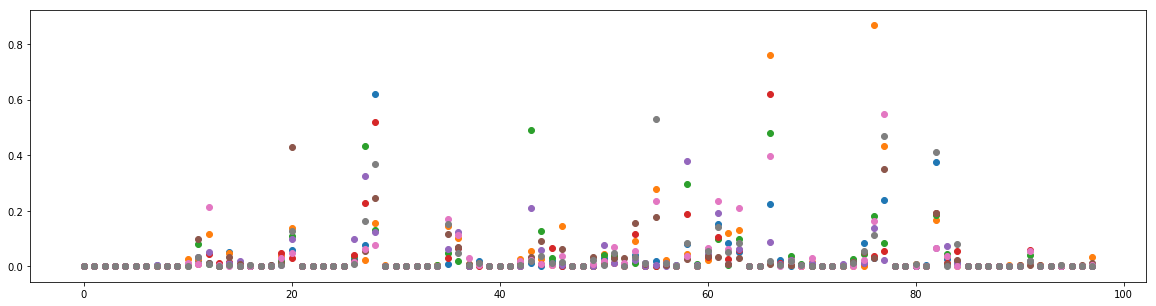

In [71]:
# 8 variants in testing
vs = np.array([probs_allClasses_allVariations[v]['VCA'] for v in variants])[:, ::100]

plt.figure(figsize=(20,5));
for v in variants:
    plt.scatter(range(vs.shape[1]), vs[v]);

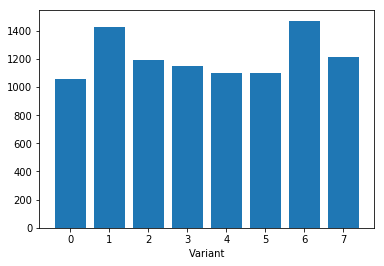

In [72]:
for structure in structures:
    plt.bar(variants, np.bincount(best_variation[structure], minlength=len(variants)))
    plt.xlabel('Variant');

In [89]:
title_viz_tuples = [("%d,%d" % (lo,hi), vizs[structures[0]])
 for (lo, hi), x in sorted(scoremap_viz_allSchemes_allFns_allStructs.items())
 for fn, vizs in x.iteritems()]

In [90]:
titles, vizs = zip(*title_viz_tuples)

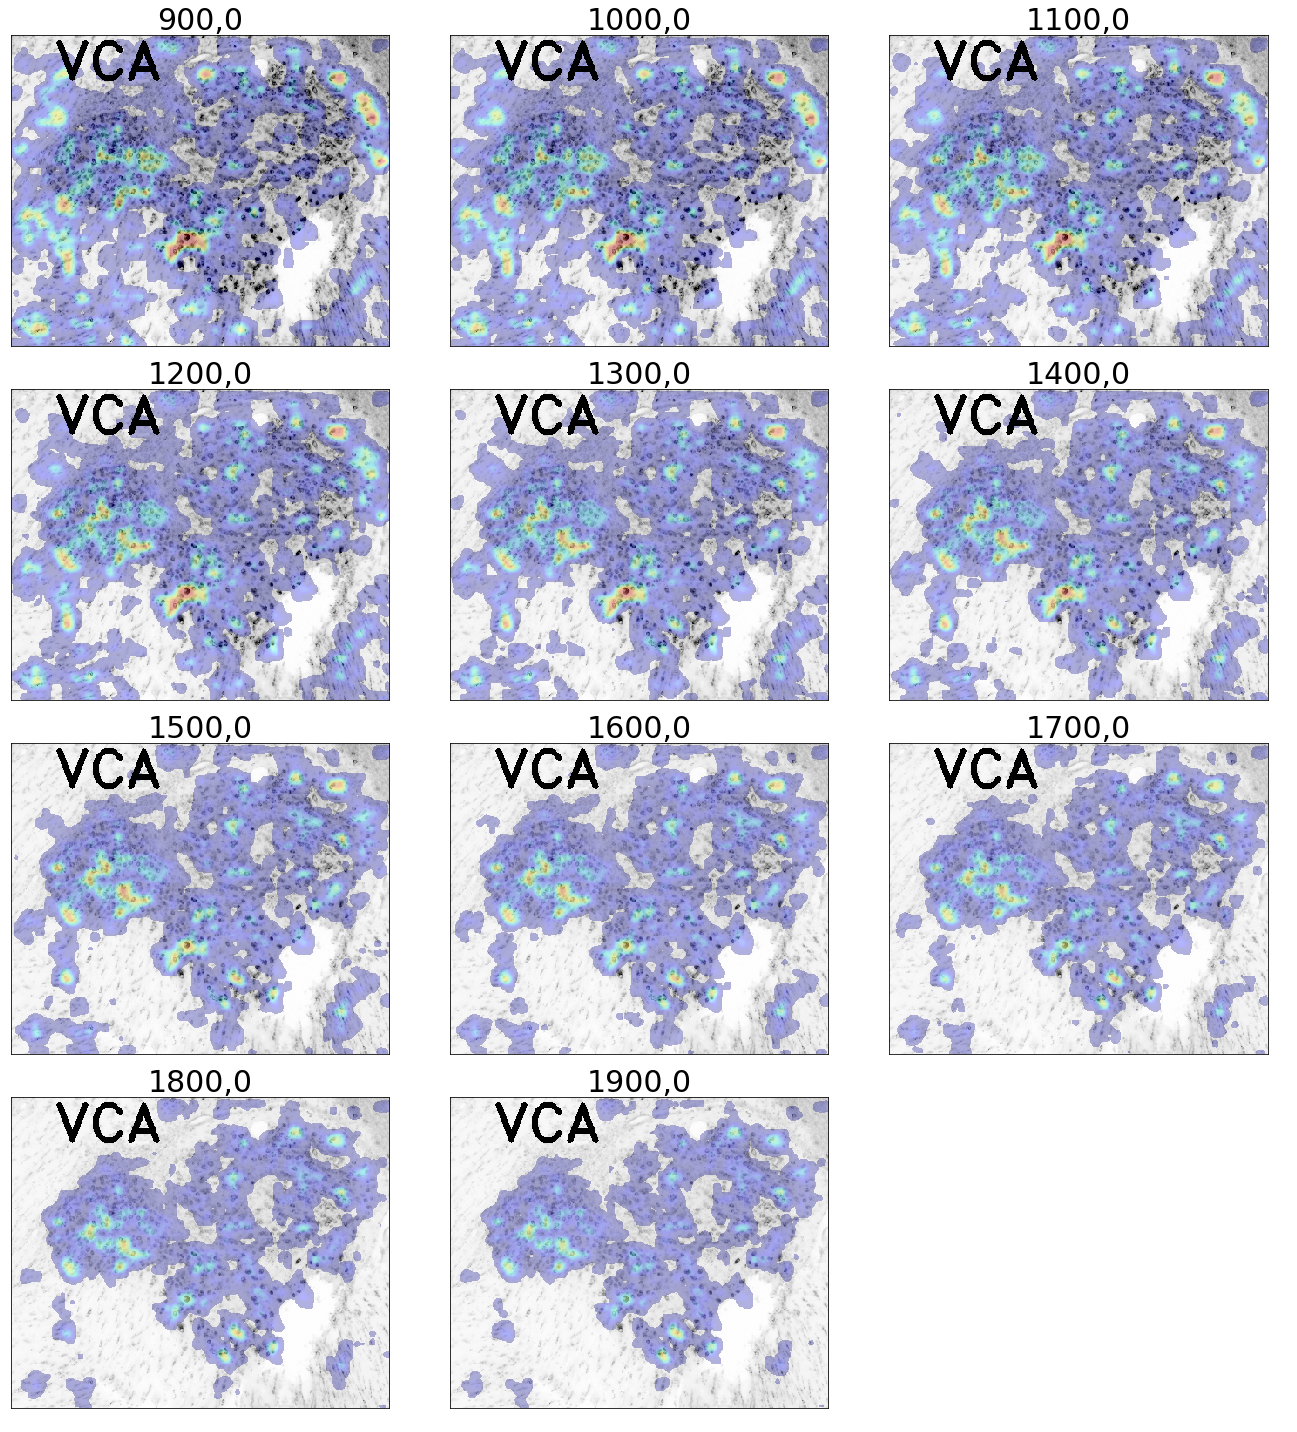

In [81]:
# no variants in testing
display_images_in_grids(vizs=vizs, titles=titles, nc=3)

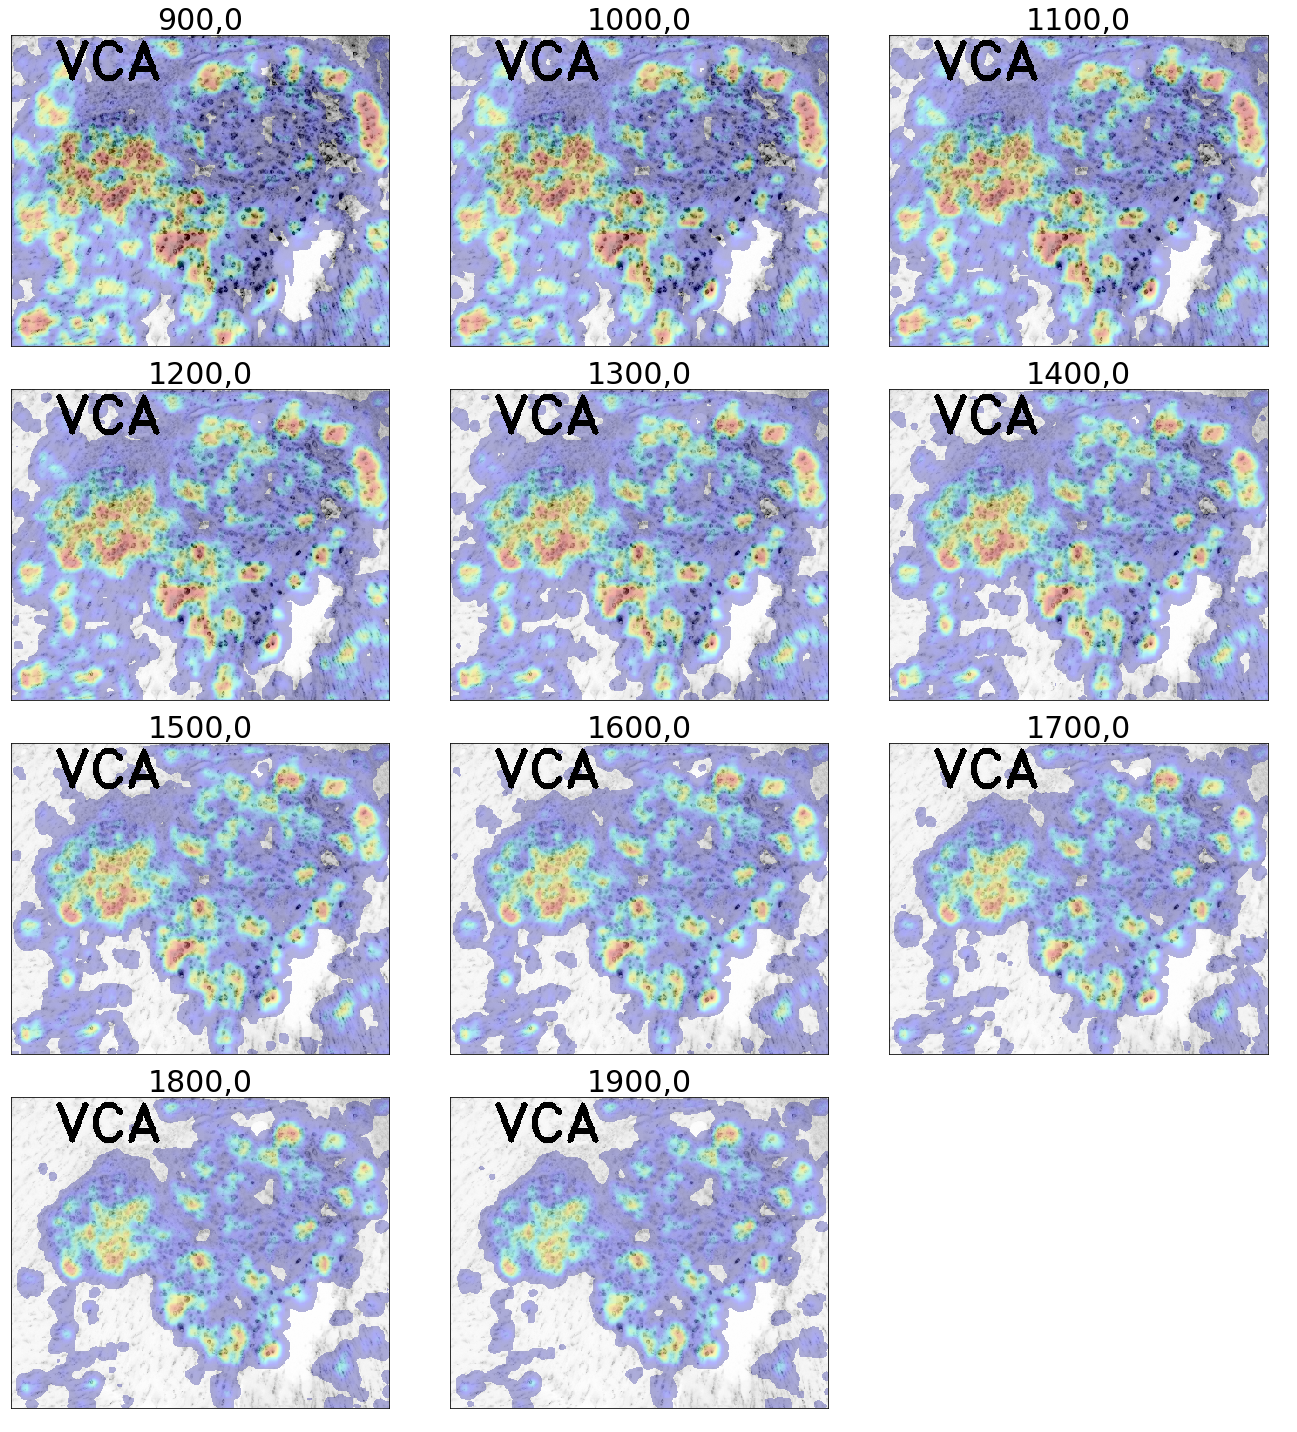

In [75]:
# 8 variants in testing
display_images_in_grids(vizs=vizs, titles=titles, nc=3)

In [27]:
viz = scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn][s].copy()
for x, y in sample_locations_roi - (roi_xmin, roi_ymin):
    cv2.circle(viz, (x,y), 5, color=(255,0,0))
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg

In [17]:
# for t, v in zip(titles, vizs):
#     plt.figure(figsize=(20,20))
#     plt.imshow(v)
#     plt.title(t)
#     plt.show();